In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import gc

# Loading Data

Load the training dataset with proteins and their GO terms.

In [2]:
train_terms = pd.read_csv("/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv",sep="\t")
train_proteins_id = np.load("/kaggle/input/t5embeds/train_ids.npy")

In [3]:
train_terms.head(3)

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO


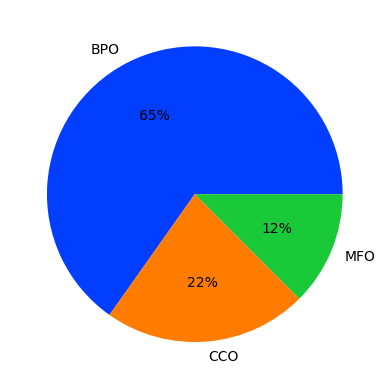

In [4]:
pie_df = train_terms['aspect'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

In [5]:
train_proteins_id

array(['P20536', 'O73864', 'O95231', ..., 'Q5RGB0', 'A0A2R8QMZ5',
       'A0A8I6GHU0'], dtype='<U10')

# Preprocessing

Group proteins terms by EntryID

In [6]:
train_terms = train_terms.groupby('EntryID')['term'].apply(lambda x: ' '.join(x)).reset_index()

In [7]:
train_terms.head(3)

,EntryID,term
0,A0A009IHW8,GO:0008152 GO:0034655 GO:0072523 GO:0044270 GO...
1,A0A021WW32,GO:0048869 GO:0048856 GO:0022008 GO:0065007 GO...
2,A0A021WZA4,GO:0071944 GO:0005575 GO:0110165 GO:0016020 GO...


Sort the terms dataframe to match the order of train_proteins_id

In [8]:
train_terms = train_terms.sort_values(by='EntryID', key=lambda x: np.argsort(train_proteins_id)).reset_index(drop=True)

In [9]:
train_terms.head(3)

,EntryID,term
0,P20536,GO:0008152 GO:0071897 GO:0044249 GO:0006259 GO...
1,O73864,GO:0061371 GO:0048589 GO:0051641 GO:0048856 GO...
2,O95231,GO:0006357 GO:0010557 GO:0045935 GO:0065007 GO...


Format terms to be processed by the multilabelbinarizer

In [10]:
train_terms = train_terms['term'].apply(str.split, args=(' '))


In [11]:
train_terms.head(3)

0    [GO:0008152, GO:0071897, GO:0044249, GO:000625...
1    [GO:0061371, GO:0048589, GO:0051641, GO:004885...
2    [GO:0006357, GO:0010557, GO:0045935, GO:006500...
Name: term, dtype: object

Create the labels dataframe by appliying a multilabelbinarizer on lists of terms

In [12]:
mlb = MultiLabelBinarizer()
#labels_np = mlb.fit_transform(train_terms_gb)
labels_df = pd.DataFrame(mlb.fit_transform(train_terms), columns=mlb.classes_)

In [13]:
labels_df.head()

,GO:0000001,GO:0000002,GO:0000003,GO:0000006,GO:0000007,GO:0000009,GO:0000010,GO:0000011,GO:0000012,GO:0000014,...,GO:2001305,GO:2001306,GO:2001307,GO:2001308,GO:2001310,GO:2001311,GO:2001313,GO:2001315,GO:2001316,GO:2001317
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
labels_df = labels_df.astype('int8')

We delete feature that have less than 5 occurences.

In [15]:
cols_to_drop = labels_df.loc[:, labels_df.sum() <= 5].columns

In [16]:
len(cols_to_drop)

12896

In [17]:
labels_df.drop(columns=cols_to_drop, inplace=True)

In [18]:
labels_df.shape

(142246, 18570)

# Models

We import embedded matrix of proteins and convert it to dataframe

In [19]:
train_embeddings = np.load('/kaggle/input/t5embeds/train_embeds.npy')

# Now lets convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = train_embeddings.shape[1]
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)



(142246, 1024)


In [20]:
train_df = train_df.astype("float32")

In [21]:
train_df.head(3)

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234


## MultiOutputClassifier

In [22]:
#clf = MultiOutputClassifier(LogisticRegression()).fit(train_df, labels_df)

## CNN

In [23]:
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [24]:
num_of_labels = labels_df.shape[1]

In [25]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                     labels_df:  2.5 GiB
              train_embeddings:  1.1 GiB
                      train_df: 555.6 MiB
                   train_terms: 53.2 MiB
             train_proteins_id:  5.4 MiB
                            _5:  5.4 MiB
                           _13:  1.2 MiB
                  cols_to_drop: 843.8 KiB
                             _: 12.1 KiB
                           _21: 12.1 KiB


In [26]:
%whos

Variable              Type                   Data/Info
------------------------------------------------------
MultiLabelBinarizer   type                   <class 'sklearn.preproces<...>bel.MultiLabelBinarizer'>
cols_to_drop          Index                  Index(['GO:0000006', 'GO:<...>e='object', length=12896)
column_num            int                    1024
gc                    module                 <module 'gc' (built-in)>
labels_df             DataFrame                      GO:0000001  GO:00<...>246 rows x 18570 columns]
mlb                   MultiLabelBinarizer    MultiLabelBinarizer()
name                  str                    _21
np                    module                 <module 'numpy' from '/op<...>kages/numpy/__init__.py'>
num_of_labels         int                    18570
palette_color         _ColorPalette          [(0.00784313725490196, 0.<...>0.8431372549019608, 1.0)]
pd                    module                 <module 'pandas' from '/o<...>ages/pandas/__init__.py

### Training

In [27]:
INPUT_SHAPE = [train_df.shape[1]]
BATCH_SIZE = 2560

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=num_of_labels,activation='sigmoid')
])


# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()],
)

history = model.fit(
    train_df, labels_df,
    batch_size=BATCH_SIZE,
    epochs=5
)

Epoch 1/5
56/56 [==============================] - 306s 5s/step - loss: 0.0741 - binary_accuracy: 0.9848 - auc: 0.2927
Epoch 2/5
56/56 [==============================] - 288s 5s/step - loss: 0.0099 - binary_accuracy: 0.9980 - auc: 0.3584
Epoch 3/5
56/56 [==============================] - 305s 5s/step - loss: 0.0087 - binary_accuracy: 0.9981 - auc: 0.3591
Epoch 4/5
56/56 [==============================] - 287s 5s/step - loss: 0.0083 - binary_accuracy: 0.9981 - auc: 0.3574
Epoch 5/5
56/56 [==============================] - 303s 5s/step - loss: 0.0080 - binary_accuracy: 0.9981 - auc: 0.3584


<Axes: title={'center': 'Accuracy'}>

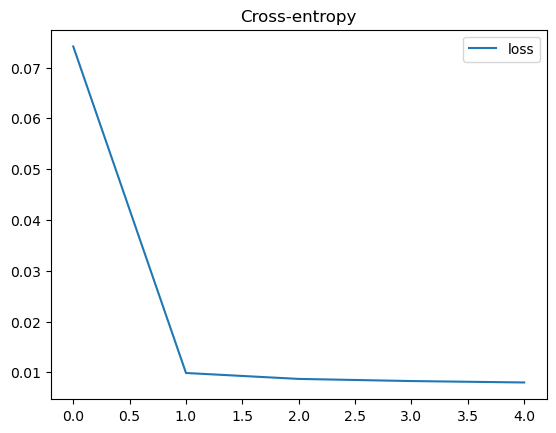

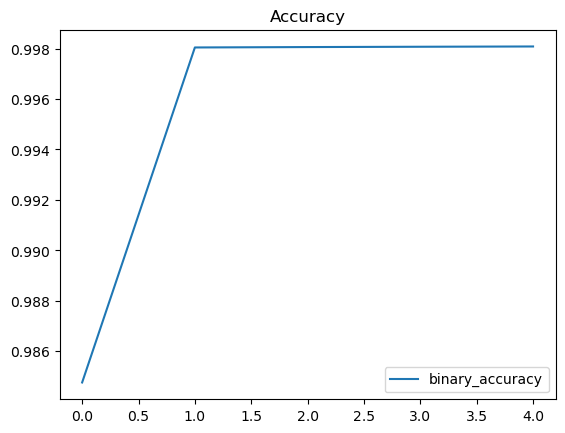

In [28]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy']].plot(title="Accuracy")

In [29]:
model.save('simple_keras.keras')

# Submission

In [30]:
test_embeddings = np.load('/kaggle/input/t5embeds/test_embeds.npy')

# Convert test_embeddings to dataframe
column_num = test_embeddings.shape[1]
test_df = pd.DataFrame(test_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(test_df.shape)

(141865, 1024)


In [31]:
del labels_df
del test_embeddings
del train_embeddings
gc.collect()

4791

In [32]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                       test_df:  1.1 GiB
                      train_df: 555.6 MiB
                   train_terms: 53.2 MiB
             train_proteins_id:  5.4 MiB
                            _5:  5.4 MiB
                           _13:  1.2 MiB
                  cols_to_drop: 843.8 KiB
                           ___: 12.1 KiB
                           _21: 12.1 KiB
                            _9:  3.3 KiB


In [33]:
test_df.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.054705,0.063420,-0.015320,-0.016506,0.042195,0.021592,-0.118535,-0.063298,-0.046146,-0.102311,...,-0.019581,-0.043712,-0.072322,0.002404,0.018459,-0.047278,0.012195,-0.043319,0.036009,0.063093
1,0.090373,0.089842,-0.023887,-0.011446,0.051465,0.020982,-0.110989,-0.066646,-0.041259,-0.087551,...,-0.024399,-0.041957,-0.066329,0.006856,0.028449,-0.053758,0.009699,-0.053350,0.019644,0.079630
2,0.043588,0.039572,-0.014332,-0.011769,0.045109,0.015847,-0.103339,-0.047735,-0.022730,-0.091452,...,-0.029648,-0.037944,-0.046043,0.003603,0.018028,-0.030746,0.003671,-0.044464,0.030974,0.040322
3,0.055668,0.049560,-0.019646,-0.006977,0.039897,0.021177,-0.108079,-0.047191,-0.031517,-0.100057,...,-0.023210,-0.041704,-0.048440,0.006088,0.020110,-0.046751,-0.006635,-0.041455,0.016683,0.057030
4,0.022637,0.014306,-0.002696,-0.034456,0.034854,0.020822,-0.114046,-0.050019,-0.026491,-0.097928,...,-0.019185,-0.032108,-0.051394,0.008448,0.015208,-0.037987,0.030977,-0.042407,0.041232,0.047161


In [34]:
gc.collect()

0

In [ ]:
model.predict(test_df, batch_size = BATCH_SIZE)
keras.backend.clear_session()
gc.collect()

56/56 [==============================] - 34s 606ms/step


In [ ]:
# Reference: https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary

df_submission = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])
test_protein_ids = np.load('/kaggle/input/t5embeds/test_ids.npy')
l = []
for k in list(test_protein_ids):
    l += [ k] * predictions.shape[1]   

df_submission['Protein Id'] = l
df_submission['GO Term Id'] = labels * predictions.shape[0]
df_submission['Prediction'] = predictions.ravel()
df_submission.to_csv("submission.tsv",header=False, index=False, sep="\t")